#**Step 1: Install All the Required Packages**

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

#**Step 2: Import All the Required Libraries**

In [ ]:

import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

#**In case of Llama 2, the following prompt template is used for the chat models**

System Prompt (optional) to guide the model


User prompt (required) to give the instruction


Model Answer (required)

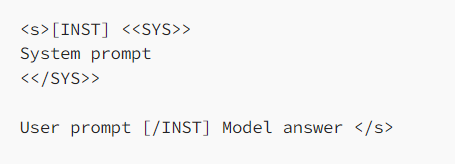

#We will reformat our instruction dataset to follow Llama 2 template.

complete code for data reformatting

https://colab.research.google.com/drive/17qGndcc0McJg6bB66yspmTDIpJXcMOVO?usp=sharing

#**How to fine tune Llama 2**

- Free Google Colab offers a 15GB Graphics Card (Limited Resources --> Barely enough to store Llama 2–7b’s weights)

- We also need to consider the overhead due to optimizer states, gradients, and forward activations

- Full fine-tuning is not possible here: we need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.

- To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.

#**Step 3**

1. Load a llama-2-7b-chat-hf model (chat model)
2. Train it on the costum dataset, which will produce our fine-tuned model Llama-2-7b-chat-finetune

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "/content/train (3).csv"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Step 4:Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [ ]:
# Load dataset (you can process it here)
dataset = load_dataset('csv',data_files = dataset_name)

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

##getting some outputs from the non-fine-tuned model

In [ ]:
text = ['hello','who is your creator','what is the location of your university','what are the departments in your university','bye']
device = "cuda:0"
for question in text:
  input = tokenizer(question, return_tensors="pt").to(device)
  output = model.generate(**input, max_new_tokens=20)
  print(tokenizer.decode(output[0], skip_special_tokens=True))




/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


hello@the-digital-humanities. nobody.no. The Digital Humanities is a field
who is your creator?
 Unterscheidung between a creator and a developer?

A creator is someone who brings
what is the location of your university?
 Unterscheidung von university und college is a common question that many students ask when they are applying to
what are the departments in your university?
 Unterscheidung between the different departments in a university can be a bit tricky, as different univers
bye bye, baby!
 nobody likes a tattle tale. 😉



In [ ]:
# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset['train'],
    peft_config=peft_config,
    dataset_text_field="train",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


{'loss': 4.1605, 'learning_rate': 0.00019827206467064133, 'epoch': 0.09}
{'loss': 2.3715, 'learning_rate': 0.00018883502507930042, 'epoch': 0.18}
{'loss': 2.003, 'learning_rate': 0.0001719339800338651, 'epoch': 0.27}
{'loss': 1.7232, 'learning_rate': 0.0001489889718238087, 'epoch': 0.36}
{'loss': 1.4091, 'learning_rate': 0.00012192786241879033, 'epoch': 0.45}
{'loss': 1.2601, 'learning_rate': 9.302435262558747e-05, 'epoch': 0.54}
{'loss': 1.2266, 'learning_rate': 6.470694352861312e-05, 'epoch': 0.63}
{'loss': 1.1256, 'learning_rate': 3.935489146011869e-05, 'epoch': 0.72}
{'loss': 0.9062, 'learning_rate': 1.9098300562505266e-05, 'epoch': 0.81}
{'loss': 0.978, 'learning_rate': 5.639149360641649e-06, 'epoch': 0.9}
{'loss': 0.8604, 'learning_rate': 1.0828886614754341e-07, 'epoch': 0.99}
{'train_runtime': 246.0148, 'train_samples_per_second': 4.536, 'train_steps_per_second': 1.134, 'train_loss': 1.6298104050338909, 'epoch': 1.0}


TrainOutput(global_step=279, training_loss=1.6298104050338909, metrics={'train_runtime': 246.0148, 'train_samples_per_second': 4.536, 'train_steps_per_second': 1.134, 'train_loss': 1.6298104050338909, 'epoch': 1.0})

In [ ]:
# Save trained model
trainer.model.save_pretrained(new_model)

##**Step 5: Check the plots on tensorboard, as follows**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3908), started 0:08:46 ago. (Use '!kill 3908' to kill it.)

<IPython.core.display.Javascript object>

###**Step 6:Use the text generation pipeline to ask questions  Note that we will not be formatting the input to match Llama 2 prompt template.**

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompts = ['hello','who is your creator','what is the location of your university','what are the departments in your university','bye']
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=50)
for prompt in prompts:

  result = pipe(f"<s>[INST] {prompt} [/INST]")
  text = result[0]['generated_text']
  n = len(text)
  i = 0
  pos = -1
  while(i<n):
      if(text[i]=='.'or text[i]=='!' or text[i]=='?'):
        pos = i
      i = i+1

  print(text[:pos])



<s>[INST] hello [/INST] Hello! How can I help you
<s>[INST] who is your creator [/INST] College students who have completed their graduation can ask questions regarding college and can share information regarding college with other students. everybody else please ask question regarding your respective department
<s>[INST] what is the location of your university [/INST] Our university is located at <a target="_blank" href="ADD YOUR UNIVERSITY DETAIL LINK OR ADD YOU OWN 
<s>[INST] what are the departments in your university [/INST] Our university offers Information Technology, computer Engineering, Mechanical engineering,Chemical engineering, Civil engineering and extc Engineering
<s>[INST] bye [/INST] Come back soon


In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

20933

#**Step 7: Store New Llama2 Model (Llama-2-7b-chat-finetune)**

How can we store our new Llama-2-7b-chat-finetune model now? We need to merge the weights from LoRA with the base model. Unfortunately, as far as I know, there is no straightforward way to do it: we need to reload the base model in FP16 precision and use the peft library to merge everything.

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You can now use this model for inference by loading it like any other Llama 2 model from the Hub.

In [ ]:
from flask import Flask, render_template, request, jsonify


from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


# tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
# model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

app = Flask(__name__)

@app.route("/")
def index():
    return render_template('chat.html')


@app.route("/get", methods=["GET", "POST"])
def chat():
    msg = request.form["msg"]++++
    input = msg
    return get_Chat_response(input)


def get_Chat_response(text):

    # Let's chat for 5 lines
    for step in range(5):
        # encode the new user input, add the eos_token and return a tensor in Pytorch
        new_user_input_ids = tokenizer.encode(str(text) + tokenizer.eos_token, return_tensors='pt')

        # append the new user input tokens to the chat history
        bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

        # generated a response while limiting the total chat history to 1000 tokens,
        chat_history_ids = model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id)

        # pretty print last ouput tokens from bot
        return tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)


if __name__ == '__main__':
    app.run()
